# Extracting Spatial Data

Subsetting and extracting data is useful when we want to select or analyze a portion of the dataset based on a feature's location, attribute, or its spatial relationship to another dataset.

In this chapter, we will explore three ways that data from a GeoDataFrame can be subsetted and extracted: clip, select location by attribute, and select by location.

## Setup

First, let's import the necessary modules.

In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon

We will utilize shapefiles of San Francisco Bay Area county boundaries and wells within the Bay Area and the surrounding 50 km. We will first load in the data and reproject the data.

```{important} All the data must have the same coordinate system in order for extraction to work correctly.
```

In [2]:
# Load data

# County boundaries
# Source: https://opendata.mtc.ca.gov/datasets/san-francisco-bay-region-counties-clipped?geometry=-125.590%2C37.123%2C-119.152%2C38.640
counties = gpd.read_file("../../pygis/_static/e_vector_shapefiles/sf_bay_counties/sf_bay_counties.shp")

# Well locations
# Source: https://gis.data.ca.gov/datasets/3a3e681b894644a9a95f9815aeeeb57f_0?geometry=-123.143%2C36.405%2C-119.230%2C37.175
# Modified by author so that only the well locations within the counties and the surrounding 50 km were kept
wells = gpd.read_file("../../pygis/_static/e_vector_shapefiles/sf_bay_wells_50km/sf_bay_wells_50km.shp")

# Reproject data to NAD83(HARN) / California Zone 3
# https://spatialreference.org/ref/epsg/2768/
proj = 2768
counties = counties.to_crs(proj)
wells = wells.to_crs(proj)

We will also create a rectangle over a part of the Bay Area. We have identified coordinates to use for this rectangle, but you can also use [bbox finder](http://bboxfinder.com/) to generate custom bounding boxes and obtain their coordinates (click the + below to show code cell).

In [3]:
# Create list of coordinate pairs
coordinates = [[1790787, 736108], [1929652, 736108], [1929652, 598414], [1790787, 598414]]

# Create a Shapely polygon from the coordinate-tuple list
poly_shapely = Polygon(coordinates)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
poly = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = "EPSG:2768")

We'll define some functions to make displaying and mapping our results a bit easier.

In [12]:
def display_table(table_name, attribute_table):
    '''Display the first and last five rows of attribute table.'''

    # Print title
    print("Attribute Table: {}".format(table_name))

    # Print number of rows and columns
    print("\nTable shape (rows, columns): {}".format(attribute_table.shape))

    # Display first two rows of attribute table
    print("\nFirst two rows:")
    display(attribute_table.head(2))

    # Display last two rows of attribute table
    print("\nLast two rows:")
    display(attribute_table.tail(2))


def plot_df(result_name, result_df, result_geom_type, area = None):
    '''Plot the result on a map and add the outlines of the original shapefiles.'''

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))

    # Plot data depending on vector type
    # For points
    if result_geom_type == "point":

        # Plot data
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
        wells.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 3)
        result_df.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)

    # For polygons
    else:

        # Plot overlay data
        result_df.plot(ax = ax, cmap = 'Set2', edgecolor = 'black')

        # Plot outlines of original shapefiles
        counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')

    # Add additional outlined boundary if specified
    if area is not None:

        # Plot data
        area.plot(ax = ax, color = 'none', edgecolor = 'red', linewidth = 3)

    # Else, pass
    else:
        pass

    # Stylize plots
    plt.style.use('bmh')

    # Set title
    ax.set_title(result_name, fontdict = {'fontsize': '15', 'fontweight' : '3'})

Let's take a look at what our input data looks like.

Text(0.5, 1.0, 'San Francisco Bay Area')

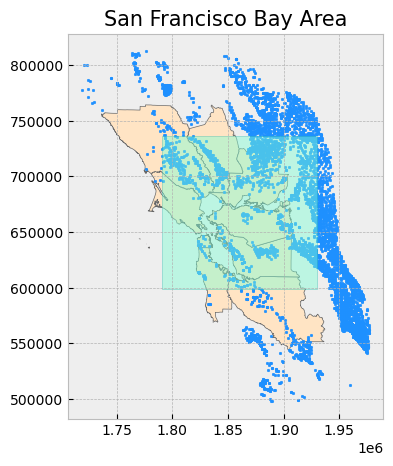

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

# Plot data
counties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
wells.plot(ax = ax, marker = 'o', color = 'dodgerblue', markersize = 3)
poly.plot(ax = ax, color = 'aquamarine', edgecolor = 'lightseagreen', alpha = 0.45)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('San Francisco Bay Area', fontdict = {'fontsize': '15', 'fontweight' : '3'})

## Clip Spatial Polygons

Clip extracts and keeps only the geometries of a vector feature that are within extent of another vector feature (think of it like a cookie-cutter or mask). We can use  `clip()` in `geopandas`, with the first parameter being the vector that will be clipped and the second parameter being the vector that will define the extent of the clip. *All attributes for the resulting clipped vector will be kept.*

```{note}
This function is only available in the more recent versions of `geopandas`.
```

We will first clip the Bay Area counties polygon to our created rectangle polygon.

,coname,geometry
6,Santa Clara County,"MULTIPOLYGON (((1858743.389 607583.832, 185874..."
5,San Mateo County,"MULTIPOLYGON (((1850037.244 614954.64, 1850859..."
0,Alameda County,"MULTIPOLYGON (((1860073.077 612066.462, 185990..."
4,San Francisco County,"MULTIPOLYGON (((1834350.912 641735.721, 183437..."
1,Contra Costa County,"MULTIPOLYGON (((1836498.14 656511.674, 1836495..."
2,Marin County,"MULTIPOLYGON (((1830505.126 653828.366, 183051..."
7,Solano County,"MULTIPOLYGON (((1875491.252 673069.363, 187548..."
8,Sonoma County,"POLYGON ((1813605.098 736060.762, 1813555.586 ..."
3,Napa County,"POLYGON ((1860170.736 724644.473, 1860169.835 ..."


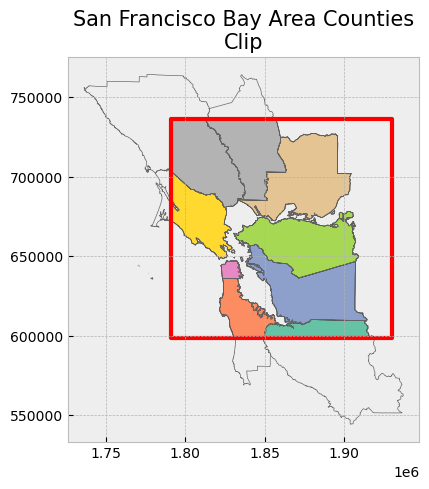

In [14]:
# Clip data
clip_counties = gpd.clip(counties, poly)

# Display attribute table
display(clip_counties)

# Plot clip
plot_df(result_name = "San Francisco Bay Area Counties\nClip", result_df = clip_counties, result_geom_type = "polygon", area = poly)

We can clip any vector type. Next, we will clip the wells point data to our created rectangle polygon.

,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
4764,None,Unknown,Unknown,0,POINT (1928106.578 619294.408)
4733,None,Unknown,Unknown,0,POINT (1927444.679 619366.782)
4391,None,Unknown,Unknown,0,POINT (1927051.274 621834.123)
4553,None,Unknown,Unknown,0,POINT (1926420.722 622427.938)
4554,None,Unknown,Unknown,0,POINT (1926420.722 622427.938)
...,...,...,...,...,...
5669,None,Unknown,Unknown,200,POINT (1824748.04 729726.154)
4077,None,Residential,Unknown,175,POINT (1823812.719 730423.625)
4076,None,Residential,Unknown,210,POINT (1823821.913 730445.634)
1365,202,Residential,Single Well,280,POINT (1830194.589 731335.971)


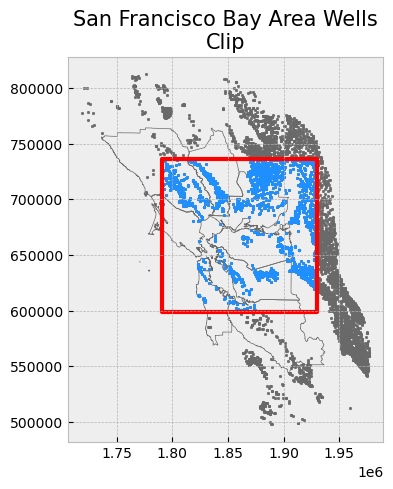

In [15]:
# Clip data
clip_wells = gpd.clip(wells, poly)

# Display attribute table
display(clip_wells)

# Plot clip
plot_df(result_name = "San Francisco Bay Area Wells\nClip", result_df = clip_wells, result_geom_type = "point", area = poly)

## Select Location by Attributes

Selecting by attribute selects only the features in a dataset whose attribute values match the specified criteria. `geopandas` uses the indexing and selection methods  in `pandas`, so data in a GeoDataFrame can be selected and queried in the same way a `pandas` dataframe can.

We will use use different criteria to subset the wells dataset.

In [16]:
# Display attribute table
display(wells.head(2))

,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
0,2400064-001,Public Supply,Single Well,0,POINT (1968290.923 592019.918)
1,2400099-001,Public Supply,Single Well,0,POINT (1969113.543 595876.691)


The criteria can use a variety of operators, including comparison and logical operators.

In [17]:
# Select wells that are public supply
wells_public = wells[(wells["WELL_USE"] == "Public Supply")]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells - Public Supply", attribute_table = wells_public)

Attribute Table: San Francisco Bay Area Wells - Public Supply

Table shape (rows, columns): (33, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
0,2400064-001,Public Supply,Single Well,0,POINT (1968290.923 592019.918)
1,2400099-001,Public Supply,Single Well,0,POINT (1969113.543 595876.691)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
3368,Aptos Creek PW,Public Supply,Single Well,713,POINT (1875127.938 553764.966)
3369,Country Club PW,Public Supply,Single Well,495,POINT (1877219.818 552137.819)


In [18]:
# Select wells that are public supply and have a depth greater than 50 ft
wells_public_deep = wells[(wells["WELL_USE"] == "Public Supply") & (wells["WELL_DEPTH"] > 50)]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft", attribute_table = wells_public_deep)

Attribute Table: San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft

Table shape (rows, columns): (24, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
919,Granite Way PW,Public Supply,Single Well,670,POINT (1875403.34 554078.279)
1082,Aptos Jr. High 2 PW,Public Supply,Single Well,590,POINT (1876872.389 553821.138)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
3368,Aptos Creek PW,Public Supply,Single Well,713,POINT (1875127.938 553764.966)
3369,Country Club PW,Public Supply,Single Well,495,POINT (1877219.818 552137.819)


In [19]:
# Select wells that are public supply and have a depth greater than 50 ft OR are residential
wells_public_deep_residential = wells[((wells["WELL_USE"] == "Public Supply") & (wells["WELL_DEPTH"] > 50)) | (wells["WELL_USE"] == "Residential")]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft or Residential", attribute_table = wells_public_deep_residential)

Attribute Table: San Francisco Bay Area Wells - Public Supply with Depth Greater than 50 ft or Residential

Table shape (rows, columns): (725, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
137,None,Residential,Unknown,78,POINT (1886296.744 730378.969)
138,None,Residential,Unknown,80,POINT (1877320.295 730464.652)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
6032,GV FARM,Residential,Single Well,67,POINT (1855297.377 693189.634)
6033,None,Residential,Unknown,76,POINT (1841755.238 707939.225)


## Select by Location

Selecting by location selects features based on its relative spatial relationship with another dataset. In other words, features are selected based on their location relative to the location of another dataset.

For example:
* to know how many wells there are in Santa Clara County, we could select all the wells that fall within Santa Clara County boundaries (which we do in one of the examples below)
* to know what rivers flow through Santa Clara County, we could select all the river polylines that intersect with Santa Clara County boundaries

For more information on selecting by location and spatial relationships, check out this [ArcGIS documentation](https://desktop.arcgis.com/en/arcmap/10.3/map/working-with-layers/using-select-by-location.htm).

There are multiple spatial relationships available in `geopandas`: 

| Spatial Relationship | Function(s) | Description |
| :------------ | ------------------ | ----------------------------------: |
| contains | `contains()` | geometry encompasses the other geometryâ€™s boundary and interior without any boundaries touching |
| covers | `covers()` | all of the geometry's points are to the exterior of the other geometry's points |
| covered by | `covered_by()` | all of the geometry's points are to the interior of the other geometry's points |
| crosses | `crosses()` | geometry's interior intersects that of the other geometry, provided that the geometry does not contain the other and the dimension of the intersection is less than the dimension of either geometry |
| disjoint | `disjoint()` | geometry's boundary and interior do not intersect the boundary and interior of the other geometry |
| equal geometry | `geom_equals()`, `geom_almost_equals()`, `geom_equals_exact()` | geometry's boundary, interior, and exterior matches (within a range) those of the other |
| intersects | `intersects()` | geometry's boundary or interior touches or crosses any part of the other geometry |
| overlaps | `overlaps()` | geometry shares at least one point, but not all points, with the other geometry, provided that the geometries and the intersection of their interiors all have the same dimensions |
| touches | `touches()` | geometry shares at least one point with the other geometry, provided that no part of the geometry's interior intersects with the other geometry |
| within | `within()` | geometry is enclosed in the other geometry (geometry's boundary and interior intersects with the other geometry's interior only) |

```{note}
The functions for these spatial relationships will generally output a `pandas` series with Boolean values (`True` or `False`) whose indexing corresponds with the input dataset (from where we want to subset the data). We can use these Boolean values to subset the dataset (where only the rows that have a `True` output will be retained).
```

### Method 1 - Shapely vector

These functions can be used to select features that have the specified spatial relationship with a single Shapely vector.

Attribute Table: San Francisco Bay Area Wells within a User-Defined Rectangle

Table shape (rows, columns): (2013, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
2,Flag City Well 3,Unknown,Single Well,0,POINT (1922067.711 679380.918)
14,Flag City Well 1,Unknown,Single Well,170,POINT (1922680.537 679641.516)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
6032,GV FARM,Residential,Single Well,67,POINT (1855297.377 693189.634)
6033,None,Residential,Unknown,76,POINT (1841755.238 707939.225)


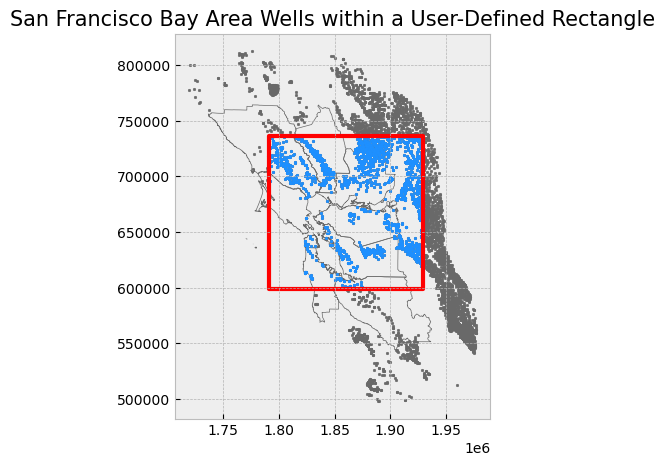

In [20]:
# Select wells that fall within Shapely rectangle
wells_within_rect_shapely = wells[wells.within(poly_shapely)]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells within a User-Defined Rectangle", attribute_table = wells_within_rect_shapely)

# Plot selection
plot_df(result_name = "San Francisco Bay Area Wells within a User-Defined Rectangle", result_df = wells_within_rect_shapely, result_geom_type = "point", area = poly)

### Method 2 - GeoDataFrame

If we're trying to select features that have a specified spatial relationship with another `geopandas` object, it gets a little tricky. This is because the `geopandas` spatial relationship functions verify the spatial relationship either row by row or index by index. In other words, the first row in the first dataset will be compared with the corresponding row or index in the second dataset, the second row in the first dataset will be compared with the corresponding row or index in the second dataset, and so on.

As a result, the number of rows need to correspond or the indices numbers need to match between the two datasets--or else we'll get a warning and the output will be empty.

Because each record in a GeoDataFrame has a geometry column that stores that record's geometry as a `shapely` object, we can call this object if we want to check a bunch of features against one extent (with one geometry).

Attribute Table: San Francisco Bay Area Wells within Santa Clara County

Table shape (rows, columns): (136, 5)

First two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
980,CalFire Pacheco No 2,Residential,Single Well,0,POINT (1924674.853 557296.117)
1020,05S02W35R002,Observation,Part of a nested/multi-completion well,80,POINT (1863211.218 606236.916)



Last two rows:


,WELL_NAME,WELL_USE,WELL_TYPE,WELL_DEPTH,geometry
5962,07S01W25L001,Observation,Single Well,404,POINT (1873814.137 589052.339)
6036,06S02W34B006,Observation,Single Well,152,POINT (1861394.207 597916.983)


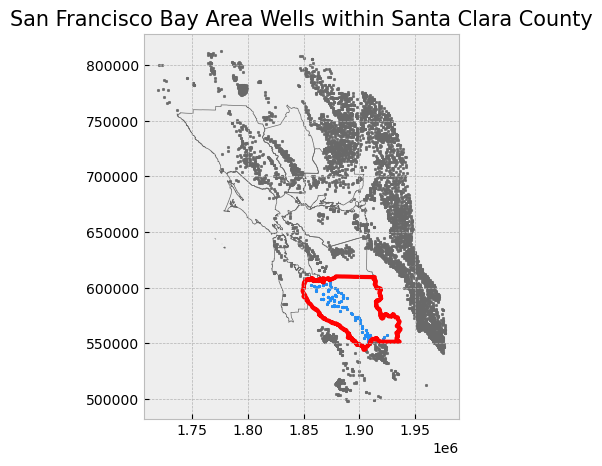

In [21]:
# Select the Santa Clara County boundary
sc_county = counties[counties["coname"] == "Santa Clara County"]

# Subset the GeoDataFrame by checking which wells are within Santa Clara County's Shapely object
wells_within_sc_shapely = wells[wells.within(sc_county.geometry.values[0])]

# Display first two and last two rows of attribute table
display_table(table_name = "San Francisco Bay Area Wells within Santa Clara County", attribute_table = wells_within_sc_shapely)

# Plot selection
plot_df(result_name = "San Francisco Bay Area Wells within Santa Clara County", result_df = wells_within_sc_shapely, result_geom_type = "point", area = sc_county)

```{tip}
If we are interested in wells that fall within two or more counties (i.e., we have multiple records that will be used for selection), we can enclose the above code in a `for` loop.
```

 [Clip Vector Data with GeoPandas, GeoPandas](https://geopandas.org/gallery/plot_clip.html)

 [Indexing and Selecting Data, GeoPandas](https://geopandas.org/docs/user_guide/indexing.html)

 [Indexing and selecting data, pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)

 [How do I select a subset of a DataFrame?, pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/03_subset_data.html)

 [GeoSeries - Binary Predicates, GeoPandas](https://geopandas.org/docs/reference/geoseries.html#binary-predicates)
                                            
 [geopandas.GeoSeries.within, GeoPandas](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.within.html)
                                            
 [Data Structures, GeoPandas](https://geopandas.org/docs/user_guide/data_structures.html)